In [ ]:
#!git clone https://github.com/whyhardt/SPICE.git

In [ ]:
# !pip install -e SPICE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from spice import SpiceEstimator, SpiceConfig, convert_dataset, BaseRNN, plot_session, split_data_along_sessiondim

# For custom RNN
import torch
import torch.nn as nn

## Load dataset

Let's load the data first with the `convert_dataset` method. This method returns a `SpiceDataset` object which we can use right away 

In [6]:
# Load your data
file = '../data/braun2018/braun2018.csv'
dataset = convert_dataset(
    file = file,
    df_participant_id='subject',
    df_choice='transition',
    df_reward='difference',  # NOTE: please verify: seems like 'pvc' is repeat_reward and 'pvo' is switch_reward; In that case difference = switch_reward - repeat_reward
    df_block='block',
    additional_inputs=['rt'],
    timeshift_additional_inputs=False,
    )

# structure of dataset:
# dataset has two main attributes: xs -> inputs; ys -> targets (next action)
# shape: (n_participants*n_blocks*n_experiments, n_timesteps, features)
# features are (n_actions * action, n_actions * reward, n_additional_inputs * additional_input, block_number, experiment_id, participant_id)

# in order to set up the participant embedding we have to compute the number of unique participants in our data 
# to get the number of participants n_participants we do:
n_participants = len(dataset.xs[..., -1].unique())
n_actions = dataset.ys.shape[-1]
n_additional_inputs = dataset.xs.shape[-1] - 2*n_actions - 3  # shape[-1] are total number of features - n_actions - reward_per_action (again n_actions) - block number - experiment_id - participant_id -> remaining additional_inputs

# timeshift the reward difference signal to be used as an stimulus
difference = dataset.xs[..., n_actions:n_actions*2]
dataset.xs = torch.concat((
    dataset.xs[:, :-1, :n_actions],
    difference[:, 1:],
    dataset.xs[:, :-1, 2*n_actions:],
), dim=-1)

# normalize additional inputs
additional_inputs = dataset.xs[..., 2*n_actions:-3]
mins = additional_inputs.nan_to_num(0).min(dim=0, keepdim=True)[0].min(dim=1, keepdim=True)[0]
maxs = additional_inputs.nan_to_num(0).max(dim=0, keepdim=True)[0].max(dim=1, keepdim=True)[0]
dataset.xs[..., 2*n_actions:-3] = (additional_inputs - mins) / (maxs - mins)

print(f"Shape of dataset: {dataset.xs.shape}")
print(f"Number of participants: {n_participants}")
print(f"Number of actions in dataset: {n_actions}")
print(f"Number of additional inputs: {dataset.xs.shape[-1]-2*n_actions-3}")

Shape of dataset: torch.Size([870, 1137, 8])
Number of participants: 73
Number of actions in dataset: 2
Number of additional inputs: 1


In [3]:
# seems like there are a few blocks that are way longer than the average block
# maybe limiting the block length to a given size would help

n_trials = np.zeros(dataset.xs.shape[0])
for index, block in enumerate(dataset.xs):
    n_trials[index] = block.shape[0]-block[:, 0].isnan().sum()
    
mean, std = n_trials.mean(), n_trials.std()
print(mean, std)

# would be okay to limit until ca 200 trials per block
dataset.xs, dataset.ys = dataset.xs[:, :int(mean+2*std)], dataset.ys[:, :int(mean+1.5*std)]

print(f"New max sequence length is {dataset.xs.shape[1]}")


118.18275862068965 62.09490272247916
New max sequence length is 242


In [ ]:
dataset_train, dataset_test = split_data_along_sessiondim(dataset, list_test_sessions=[2, 4, 6])

print(f"Number of training sessions: {dataset_train.xs.shape[0]}")
print(f"Number of test sessions: {dataset_test.xs.shape[0]}")

dataset_tuple = dataset_train.xs, dataset_train.ys, dataset_test.xs, dataset_test.ys, 

Number of training sessions: 652
Number of test sessions: 218


In [ ]:
dataset.xs[0, :, n_actions:2*n_actions]

tensor([[   nan, 0.6000],
        [0.4000,    nan],
        [0.4000,    nan],
        [0.5000,    nan],
        [   nan, 0.5500],
        [0.5000,    nan],
        [0.5000,    nan],
        [   nan, 0.6000],
        [0.5000,    nan],
        [   nan, 0.5000],
        [0.5000,    nan],
        [   nan, 0.6000],
        [0.4500,    nan],
        [   nan, 0.5000],
        [0.5000,    nan],
        [   nan, 0.6000],
        [0.4500,    nan],
        [0.5000,    nan],
        [   nan, 0.5500],
        [0.5000,    nan],
        [   nan, 0.6000],
        [0.4000,    nan],
        [   nan, 0.5000],
        [0.5000,    nan],
        [   nan, 0.5500],
        [0.5000,    nan],
        [0.5000,    nan],
        [   nan, 0.6000],
        [0.4500,    nan],
        [   nan, 0.5000],
        [0.5000,    nan],
        [   nan, 0.6000],
        [0.4500,    nan],
        [0.5000,    nan],
        [   nan, 0.5500],
        [   nan, 0.5000],
        [0.5000,    nan],
        [   nan, 0.6000],
        [0.5

## SPICE Setup

Now we are going to define the configuration for SPICE with a `SpiceConfig` object.

The `SpiceConfig` takes as arguments 
1. `library_setup (dict)`: Defining the variable names of each module.
2. `memory_state (dict)`: Defining the memory state variables and their initial values.
3. `states_in_logit (list)`: Defining which of the memory state variables are used later for the logit computation. This is necessary for some background processes.  

In [72]:
spice_config = SpiceConfig(
    library_setup={
        'value_reward_diff': ['reward_diff'],
        'value_persistance': ['repeat'],
        'wm_rt': ['repeat', 'switch', 'wm_rt[t-1]', 'wm_rt[t-2]', 'wm_rt[t-3]', 'wm_rt[t-4]']
    },
    
    memory_state={
            'value_reward_diff': 0.,
            'value_persistance': 0.,
            'value_wm_rt': 0.,
            'wm_rt[t-1]': 1.,
            'wm_rt[t-2]': 1.,
            'wm_rt[t-3]': 1.,
            'wm_rt[t-4]': 1.,
        },
    
    states_in_logit=['value_reward_diff', 'value_persistance', 'value_wm_rt'],
)

And now we are going to define the SPICE model which is a child of the `BaseRNN` and `torch.nn.Module` class and takes as required arguments:
1. `spice_config (SpiceConfig)`: previously defined SpiceConfig object
2. `n_actions (int)`: number of possible actions in your dataset (including non-displayed ones if applicable).
3. `n_participants (int)`: number of participants in your dataset.

As usual for a `torch.nn.Module` we have to define at least the `__init__` method and the `forward` method.
The `forward` method gets called when computing a forward pass through the model and takes as inputs `(inputs (SpiceDataset.xs), prev_state (dict, default: None), batch_first (bool, default: False))` and returns `(logits (torch.Tensor, shape: (n_participants*n_blocks*n_experiments, timesteps, n_actions)), updated_state (dict))`. Two necessary method calls inside the forward pass are:
1. `self.init_forward_pass(inputs, prev_state, batch_first) -> SpiceSignals`: returns a `SpiceSignals` object which carries all relevant information already processed.
2. `self.post_forward_pass(SpiceSignals, batch_first) -> SpiceSignals`: does some re-arranging of the logits to adhere to `batch_first`.

In [73]:
class SPICERNN(BaseRNN):
    
    def __init__(self, spice_config, **kwargs):
        super().__init__(spice_config=spice_config, **kwargs)
        
        # participant embedding
        self.participant_embedding = self.setup_embedding(num_embeddings=n_participants, embedding_size=self.embedding_size, dropout=0.)
                
        # set up the submodules
        self.setup_module(key_module='value_reward_diff', input_size=1+self.embedding_size)  # 6 terms
        self.setup_module(key_module='value_persistance', input_size=1+self.embedding_size)  # 6 terms
        self.setup_module(key_module='wm_rt', input_size=6+self.embedding_size)  # 36 terms
        
    def forward(self, inputs, prev_state, batch_first=False):
        
        spice_signals = self.init_forward_pass(inputs, prev_state, batch_first)
        
        repeat = spice_signals.actions[..., 0].unsqueeze(-1).repeat(1, 1, self.n_actions)  # indexing come from value conversion in convert_dataset (alphabetical); see ValueWarning in previous cell;
        switch = spice_signals.actions[..., 1].unsqueeze(-1).repeat(1, 1, self.n_actions)
        rt = spice_signals.additional_inputs[..., 0].unsqueeze(-1).repeat(1, 1, self.n_actions)
        
        # time-invariant participant features
        participant_embeddings = self.participant_embedding(spice_signals.participant_ids)
        # mask_repeat = torch.tensor((1,0)).reshape(1, self.n_actions).repeat(spice_signals.actions.shape[1], 1)  # (1, 0) comes from the mapping in convert_dataset (0: repeat, 1: switch)
        # any value updates will be applied only to the action value of switching; the repeat value will serve as an anchor since there's no uncertainty about the reward outcomes 
        mask_switch = torch.tensor((0,1)).reshape(1, self.n_actions).repeat(spice_signals.actions.shape[1], 1)
        
        for timestep in spice_signals.timesteps:
            
            # update reward value
            self.call_module(
                key_module='value_reward_diff',
                key_state='value_reward_diff',
                action_mask=mask_switch,
                inputs=(
                    spice_signals.rewards[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            # update working memory representation of last RTs
            self.call_module(
                key_module='wm_rt',
                key_state='value_wm_rt',
                action_mask=mask_switch,
                inputs=(
                    repeat[timestep],
                    switch[timestep],
                    self.state['wm_rt[t-1]'],
                    self.state['wm_rt[t-2]'],
                    self.state['wm_rt[t-3]'],
                    self.state['wm_rt[t-4]'],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            # update repeat value
            self.call_module(
                key_module='value_persistance',
                key_state='value_persistance',
                action_mask=mask_switch,
                inputs=(
                    repeat[timestep],
                    ),
                participant_index=spice_signals.participant_ids,
                participant_embedding=participant_embeddings,
            )
            
            # update working memory of RTs
            self.state['wm_rt[t-1]'], self.state['wm_rt[t-2]'], self.state['wm_rt[t-3]'], self.state['wm_rt[t-4]'] = rt[timestep], self.state['wm_rt[t-1]'], self.state['wm_rt[t-2]'], self.state['wm_rt[t-3]']
            
            # transform logits from item-space to action-space
            spice_signals.logits[timestep] = self.state['value_reward_diff'] + self.state['value_persistance'] + self.state['value_wm_rt']
            
        spice_signals = self.post_forward_pass(spice_signals, batch_first)
        
        return spice_signals.logits, self.get_state()

Let's setup now the `SpiceEstimator` object and fit it to the data!

In [89]:
path_spice = '../params/braun2018/spice_braun2018.pkl'
estimator = SpiceEstimator(
        # model paramaeters
        rnn_class=SPICERNN,
        spice_config=spice_config,
        n_actions=2,
        n_participants=n_participants,
        n_experiments=1,
        
        # rnn training parameters
        epochs=400,
        warmup_steps=100,
        learning_rate=0.01,
        
        # sindy fitting parameters
        sindy_weight=0.1,
        sindy_threshold=0.05,
        sindy_threshold_frequency=1,
        sindy_threshold_terms=1,
        sindy_cutoff_patience=100,
        sindy_epochs=1000,
        sindy_alpha=0.0001,
        sindy_library_polynomial_degree=2,
        sindy_ensemble_size=1,
        
        # additional generalization parameters
        batch_size=1024,
        bagging=True,
        scheduler=True,
        
        verbose=True,
        save_path_spice=path_spice,
    )

In [90]:
print(f"\nStarting training on {estimator.device}...")
print("=" * 80)
estimator.fit(*dataset_tuple)
# estimator.load_spice(args.model)
print("=" * 80)
print("\nTraining complete!")

# Print example SPICE model for first participant
print("\nExample SPICE model (participant 0):")
print("-" * 80)
estimator.print_spice_model(participant_id=0)
print("-" * 80)


Starting training on cpu...

Training the RNN...
Epoch 1/400 --- L(Train): 3.2192521 --- L(Val, RNN): 2.2975204 --- L(Val, SINDy): 2.4543304 --- Time: 9.69s; --- Convergence: 1.15e+00; LR: 1.00e-02; Metric: inf; Bad epochs: 0/100
--------------------------------------------------------------------------------
SPICE Model (Coefficients: 48):
value_reward_diff[t+1] = -0.0 1 + 1.0 value_reward_diff[t] + -0.0 reward_diff + 0.001 value_reward_diff^2 + 0.001 value_reward_diff*reward_diff + 0.001 reward_diff^2 
value_persistance[t+1] = -0.002 1 + 0.995 value_persistance[t] + 0.008 repeat + 0.003 value_persistance^2 + -0.007 value_persistance*repeat + 0.006 repeat^2 
wm_rt[t+1] = 0.009 1 + 1.009 wm_rt[t] + 0.01 repeat + 0.009 switch + 0.007 wm_rt[t-1] + 0.009 wm_rt[t-2] + 0.009 wm_rt[t-3] + 0.007 wm_rt[t-4] + 0.01 wm_rt^2 + 0.009 wm_rt*repeat + 0.011 wm_rt*switch + 0.01 wm_rt*wm_rt[t-1] + 0.01 wm_rt*wm_rt[t-2] + 0.01 wm_rt*wm_rt[t-3] + 0.01 wm_rt*wm_rt[t-4] + 0.007 repeat^2 + -0.001 repeat*sw

In [91]:
estimator.load_spice(path_spice)

## Benchmarking

### Benchmark Model

(add here EVC model)

### GRU Model

In [123]:
import sys

sys.path.append('../..')
from weinhardt2025.benchmarking.benchmarking_gru import GRU, training, setup_agent_gru

gru = GRU(n_actions, additional_inputs=n_additional_inputs).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)

path_gru = '../params/braun2018/gru_braun2018.pkl'


In [ ]:
gru = training(
    gru=gru,
    optimizer=optimizer,
    dataset_train=dataset_train,
    dataset_test=dataset_test,
    epochs=epochs,
    )

torch.save(gru.state_dict(), path_gru)

IndexError: The shape of the mask [210540] at index 0 does not match the shape of the indexed tensor [183570, 2] at index 0

In [94]:
gru_agent = setup_agent_gru(path_gru)

## Plot SPICE against benchmark models

value_reward_diff[t+1] = -0.426 1 + 0.126 value_reward_diff[t] + 2.445 reward_diff + -0.094 value_reward_diff^2 + 1.768 reward_diff^2 
value_persistance[t+1] = 1.0 value_persistance[t] 
wm_rt[t+1] = 1.0 wm_rt[t] + -0.57 wm_rt[t-1] + -0.144 wm_rt[t-2] 


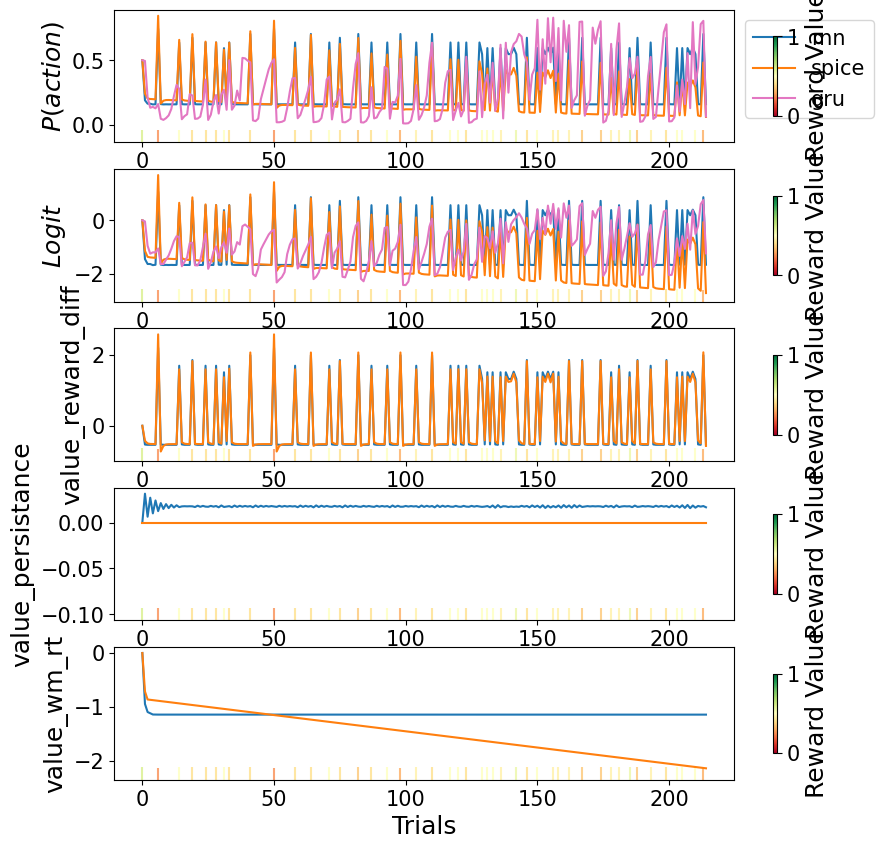

In [122]:
# plotting
participant_id = 2

estimator.print_spice_model(participant_id)

agents = {
    'rnn': estimator.rnn_agent,
    'spice': estimator.spice_agent,
    # 'evc': evc_agent,
    'gru': gru_agent,
}

mask_participant_id = dataset.xs[:, 0, -1] == participant_id

fig, axs = plot_session(
    agents, 
    dataset.xs[mask_participant_id][5], 
    signals_to_plot=['value_reward_diff', 'value_persistance', 'value_wm_rt'], 
    display_choice=1,  # display_choice=1 because switch is action index 1 (see convert_dataset -> ValueWarning in output)
    )  
plt.show()

In [112]:
dataset.xs[:, 0, -1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 